### Importing libraries and data

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
final_test_data = pd.read_csv("/content/drive/MyDrive/Data/test.csv")
train_data = pd.read_csv("/content/drive/MyDrive/Data/train.csv")

### Visualizing data and basic statics

In [47]:
train_data.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [48]:
train_data.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Maybe use this **Product ID** to check if the number of a specific Product influence the **failure rate**.

In [49]:
train_data['Product ID'].value_counts()

L53257    139
L49056    131
L53271    131
L54275    120
L48892    120
         ... 
M24614      1
H39399      1
M15853      1
H32637      1
L48036      1
Name: Product ID, Length: 9976, dtype: int64

Text(0.5, 0, 'Type')

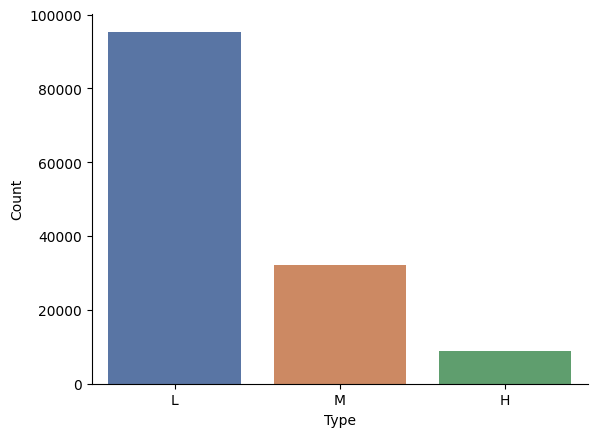

In [50]:
class_counts = train_data['Type'].value_counts()
sns.barplot(x= class_counts.index, y= class_counts.values, hue= class_counts.index, palette='deep')
sns.despine()
plt.ylabel('Count')
plt.xlabel('Type')

Text(0.5, 0, 'Failure')

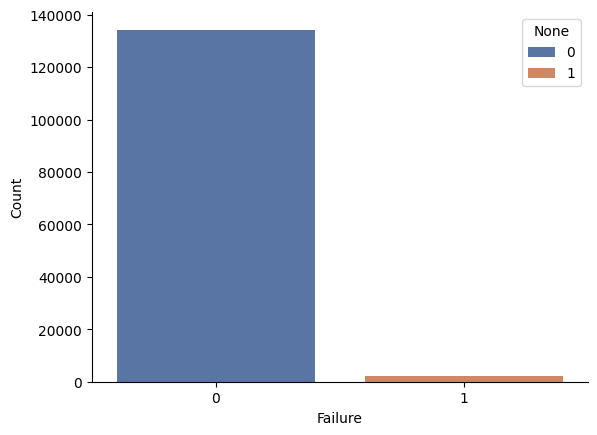

In [51]:
class_counts = train_data['Machine failure'].value_counts()
sns.barplot(x= class_counts.index, y= class_counts.values, hue= class_counts.index, palette='deep')
sns.despine()
plt.ylabel('Count')
plt.xlabel('Failure')

Very imbalanced data!!

In [52]:
train_data.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

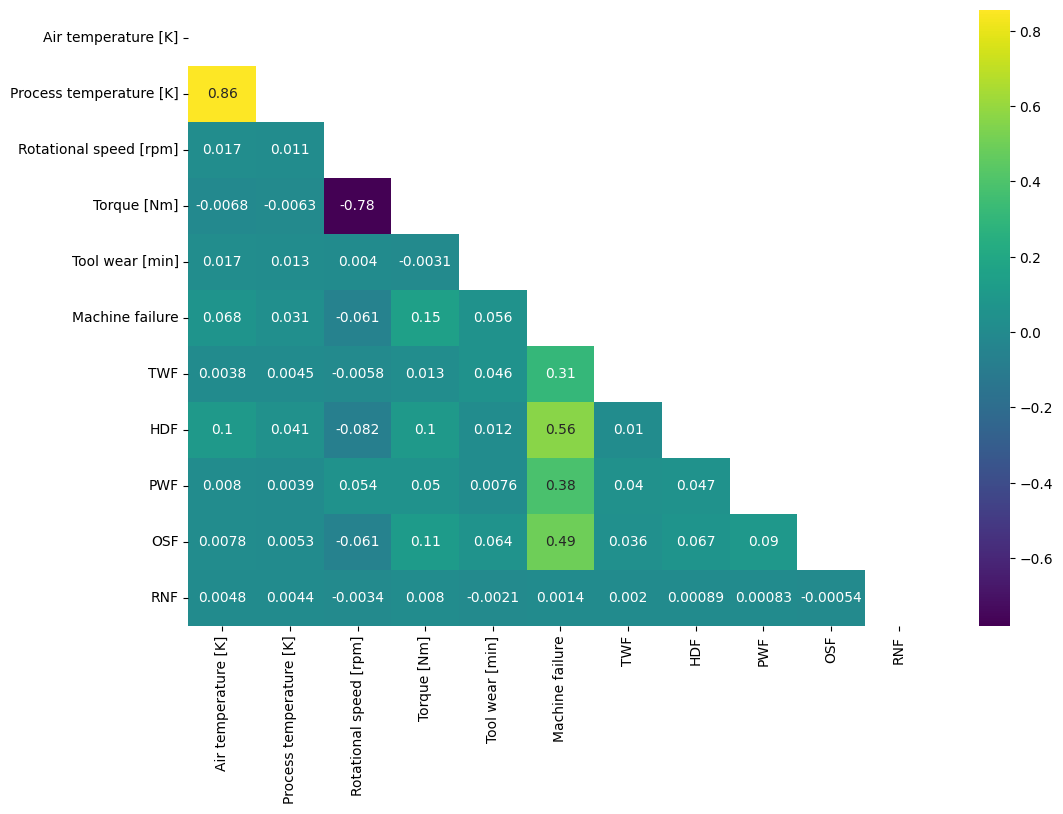

In [53]:
plt.figure(figsize=(12,8))
corr = train_data[['Air temperature [K]','Process temperature [K]',
                   'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
                   'Machine failure','TWF', 'HDF', 'PWF', 'OSF', 'RNF']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=corr, mask= mask, annot=True, cmap='viridis')
plt.show()

HDF and OSF seem to have the best correlation to the a Machine Failure

### Cleaning data function

In [54]:
def count_products(dataframe):
  #products = pd.DataFrame(dataframe['Product ID'].value_counts().reset_index())
  #products.rename(columns= {'Product ID': 'Product ID Count',
  #                          'index': 'Product ID'}, inplace=True)
  #dataframe = dataframe.merge(right= products, how= 'inner', on= 'Product ID')

  dataframe.drop(columns=['id', 'Product ID'], axis=1, inplace=True, errors='ignore')

  return dataframe

What I intended to do with this function seemed to cause trouble. The AUC and ROC curve were very low, practically the same as a random guess.

I wanted to create a column with the total amount of a single item, but since it uses sums numbers through the whole dataset, I think it causes some trouble.

# Setting up the pipeline

In [ ]:
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

import xgboost as xgb


pipeline = make_pipeline(
    FunctionTransformer(count_products),
    ColumnTransformer(
        transformers=[('onehot', OneHotEncoder(), ['Type'])],
        remainder= 'passthrough', verbose_feature_names_out = False),
    SMOTE(random_state=42),
    xgb.XGBClassifier()
)

params = {
    'xgbclassifier__booster': ['gbtree'],
    'xgbclassifier__n_estimators': [100, 300],
    'xgbclassifier__min_child_weight': [1, 10],
    'xgbclassifier__gamma': [0, 1],
    'xgbclassifier__subsample': [0.6, 1.0],
    'xgbclassifier__colsample_bytree': [0.6, 1.0],
    'xgbclassifier__max_depth': [3, 6]
}

grid = GridSearchCV(pipeline, params, cv= 3, scoring='roc_auc',verbose=2)


X = train_data.drop('Machine failure', axis=1)
y = train_data['Machine failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


grid.fit(X_train, y_train)

y_pred = grid.predict_proba(X_test)

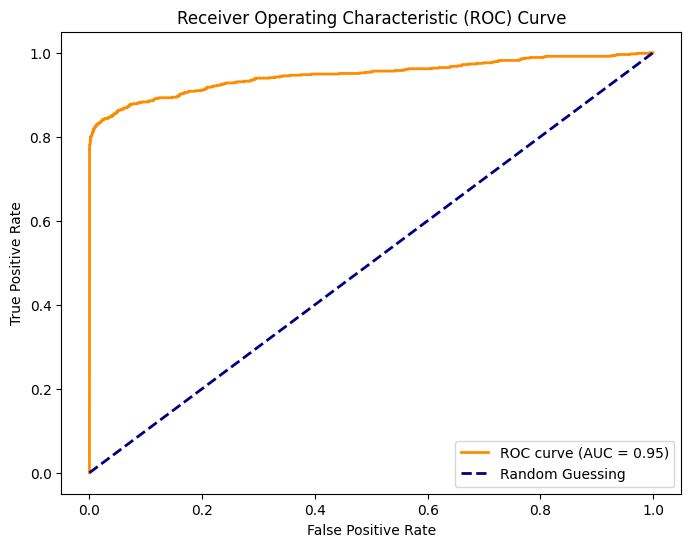

In [61]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Creating the final doc with the predictions

In [106]:
pred_final = grid.predict_proba(final_test_data)

final_df = pd.merge(left=final_test_data, right=pd.DataFrame(pred_final[:,1]), left_index=True, right_index=True)

final_df = pd.DataFrame(final_df[final_df.columns[-1]])

final_df.rename(columns={final_df.columns[0]: 'Machine Failure'}, inplace=True)

final_df = final_df['Machine Failure'].apply(lambda x: round(x, 1))

final_df.to_csv('final.csv', index_label='id')